In [27]:
import sys

sys.path.append("../")

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'
# DATA_PATH = '../data/crypto/1m'

In [54]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 'LUNA', 'AVAX', 'DOT', 'DOGE', 'MATIC', 'LTC', 'LINK']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2019-01-01'
test_end = '2020-12-01'
end_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        # df = df[df.index > '2022-01-01'].copy()
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC-USDT,ETH-USDT,BNB-USDT,XRP-USDT,ADA-USDT,SOL-USDT,LUNA-USDT,AVAX-USDT,DOT-USDT,DOGE-USDT,MATIC-USDT,LTC-USDT,LINK-USDT
open_time,,,,,,,,,,,,,
2019-09-08 17:00:00,9.210340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 18:00:00,9.210340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 19:00:00,9.243787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 20:00:00,9.244879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 21:00:00,9.248782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df.tail()

,BTC-USDT,ETH-USDT,BNB-USDT,XRP-USDT,ADA-USDT,SOL-USDT,LUNA-USDT,AVAX-USDT,DOT-USDT,DOGE-USDT,MATIC-USDT,LTC-USDT,LINK-USDT
open_time,,,,,,,,,,,,,
2022-07-06 11:00:00,9.908410,7.033013,5.465821,-1.131342,-0.786579,3.572346,NaN,2.905808,1.927455,-2.696814,-0.661261,3.912423,1.833861
2022-07-06 12:00:00,9.910657,7.034802,5.468651,-1.132583,-0.784824,3.577389,NaN,2.903617,1.927892,-2.697852,-0.657394,3.912223,1.831301
2022-07-06 13:00:00,9.914423,7.039468,5.470757,-1.128556,-0.781104,3.588506,NaN,2.910719,1.935138,-2.695331,-0.643595,3.910021,1.835457
2022-07-06 14:00:00,9.912868,7.037765,5.468862,-1.129175,-0.782197,3.587124,NaN,2.909630,1.933982,-2.698744,-0.653734,3.909821,1.832421
2022-07-06 15:00:00,9.910756,7.034960,5.466962,-1.130103,-0.783948,3.583519,NaN,2.908539,1.932101,-2.699784,-0.656622,3.908015,1.831621


In [56]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()  # [(df.index <= test_end)]
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [57]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[5.366972496574079, -3.5598792886004045]",BTC-USDT,ETH-USDT
1,"[3.6299286379175553, -1.7427909090583598]",BTC-USDT,BNB-USDT
2,"[2.886776471695522, -0.38405956025437066]",BTC-USDT,SOL-USDT
3,"[3.2187896215263323, -1.0749885557983836]",BTC-USDT,DOGE-USDT
4,"[3.507484968368094, -0.5733991074408507]",BTC-USDT,MATIC-USDT


In [58]:
coint_df.to_csv('coint_df.csv')


In [59]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df[(df.index <= test_end)].copy()
        spread = calculate_spread(df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
stationary_df

,i,pairs,half_life
8,8,"[BNB-USDT, LUNA-USDT]",1
17,17,"[LUNA-USDT, AVAX-USDT]",1
12,12,"[XRP-USDT, LUNA-USDT]",1
6,6,"[ETH-USDT, LUNA-USDT]",1
18,18,"[LUNA-USDT, DOGE-USDT]",1
15,15,"[SOL-USDT, LUNA-USDT]",1
19,19,"[LUNA-USDT, MATIC-USDT]",1
21,21,"[DOGE-USDT, MATIC-USDT]",1046
10,10,"[BNB-USDT, MATIC-USDT]",1227
5,5,"[ETH-USDT, SOL-USDT]",1484


In [65]:
selected_row = stationary_df[stationary_df['i'] == 21]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df[df.index <= test_end], selected_row, hedge_ratio)

21


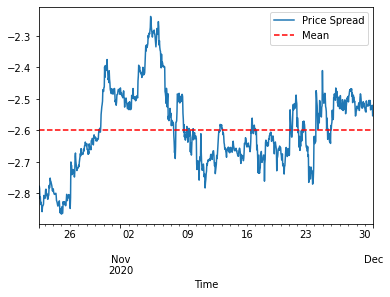

In [66]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [67]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

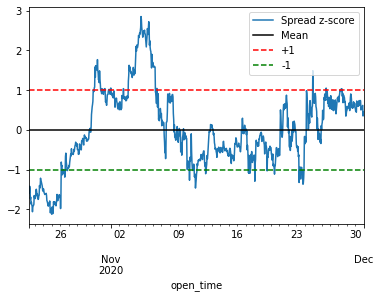

In [68]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])